In [1]:
import numpy as np 
import pandas as pd 
import os
import re
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, Dropout, Conv2DTranspose, UpSampling2D, add, Flatten, Lambda, Reshape, BatchNormalization, concatenate, AveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.python.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, TensorBoard
import matplotlib.pyplot as plt
import scipy
from PIL import Image
import random
import cv2
from tensorflow.keras.metrics import MeanAbsoluteError, MeanSquaredError, RootMeanSquaredError, Mean, binary_crossentropy, binary_accuracy
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import time

In [2]:
try:
    import google.colab
    in_colab = True
except ImportError:
    in_colab = False

if in_colab:
    try:
        tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
        print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])
        tf.config.experimental_connect_to_cluster(tpu)
        tf.tpu.experimental.initialize_tpu_system(tpu)
        tpu_strategy = tf.distribute.TPUStrategy(tpu)
    except ValueError:
        if 'GPU' in [gpu[-1] for gpu in tf.config.list_physical_devices('GPU')]:
            print('Running on Google Colab GPU')
        else:
            print('Not connected to a TPU or GPU runtime')

else:
    physical_devices = tf.config.list_physical_devices('GPU')
    print(physical_devices)
    try:
        if len(physical_devices):
            for gpu in physical_devices:
                tf.config.experimental.set_memory_growth(gpu, enable = True)
                print(f"Using local GPU: {gpu}")
            sess = tf.compat.v1.Session(config = tf.compat.v1.ConfigProto(log_device_placement = True))
        else:
            print("No local GPU found")
    except:
        print("Error Mounting a GPU")

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Using local GPU: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
Device mapping:
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: NVIDIA GeForce RTX 3060 Ti, pci bus id: 0000:01:00.0, compute capability: 8.6



In [3]:
def filter_df(df, viable_nums=["2", "4", "6"]):
    condition = df['low_res'].str.endswith(tuple(num + ".jpg" for num in viable_nums))
    filtered_df = df[condition]
    return filtered_df

In [4]:
def read_images(df):
    new_df = pd.DataFrame(columns=["low_res", "high_res"])

    for index, row in df.iterrows():
            low_res_path = row["low_res"]
            low_res_img = Image.open(low_res_path)
            low_res_array = np.array(low_res_img)

            high_res_path = row["high_res"]
            high_res_img = Image.open(high_res_path)
            high_res_array = np.array(high_res_img)
            new_row = {
                "low_res" : low_res_array,
                "high_res" : high_res_array,
            }
            new_df = pd.concat([new_df, pd.DataFrame([new_row])], ignore_index=True)
        
    return new_df

In [5]:
EPOCHS = 100
seed = 42

INPUT_SHAPE = (200, 300, 3)
IMAGE_SHAPE = (200, 300)

## Data

In [6]:
def load_and_preprocess_image(low_res_path, high_res_path):
    low_res_image = tf.io.read_file(low_res_path)
    low_res_image = tf.image.decode_jpeg(low_res_image, channels=3)
    low_res_image = tf.image.resize(low_res_image, IMAGE_SHAPE)
    low_res_image = low_res_image / 255.0

    high_res_image = tf.io.read_file(high_res_path)
    high_res_image = tf.image.decode_jpeg(high_res_image, channels=3)
    high_res_image = tf.image.resize(high_res_image, IMAGE_SHAPE)
    high_res_image = high_res_image / 255.0
    
    return low_res_image, high_res_image

def create_dataset(data, data_dir, batch_size):
    low_res_paths = data['low_res'].apply(lambda x: os.path.join(data_dir, 'low res', x)).values
    high_res_paths = data['high_res'].apply(lambda x: os.path.join(data_dir, 'high res', x)).values

    dataset = tf.data.Dataset.from_tensor_slices((low_res_paths, high_res_paths))
    dataset = dataset.map(load_and_preprocess_image)
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

    return dataset

# Define constants
BATCH_SIZE = 1
DATA_DIR = 'Data'

# Load CSV file
csv_path = os.path.join(DATA_DIR, 'image_data.csv')
df = pd.read_csv(csv_path)
df = filter_df(df, viable_nums=["6"]) # For GAN

# Split data into train, validation, and test sets
train_data, val_test_data = train_test_split(df, test_size=0.2, random_state=seed)
val_data, test_data = train_test_split(val_test_data, test_size=0.5, random_state=seed)

# Create datasets
train_dataset = create_dataset(train_data, DATA_DIR, BATCH_SIZE)
val_dataset = create_dataset(val_data, DATA_DIR, BATCH_SIZE)
test_dataset = create_dataset(test_data, DATA_DIR, BATCH_SIZE)

# Print dataset information
print("Train dataset:", train_dataset)
print("Validation dataset:", val_dataset)
print("Test dataset:", test_dataset)

Train dataset: <PrefetchDataset element_spec=(TensorSpec(shape=(None, 200, 300, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 200, 300, 3), dtype=tf.float32, name=None))>
Validation dataset: <PrefetchDataset element_spec=(TensorSpec(shape=(None, 200, 300, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 200, 300, 3), dtype=tf.float32, name=None))>
Test dataset: <PrefetchDataset element_spec=(TensorSpec(shape=(None, 200, 300, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 200, 300, 3), dtype=tf.float32, name=None))>


In [7]:
len(train_dataset) * BATCH_SIZE

1003

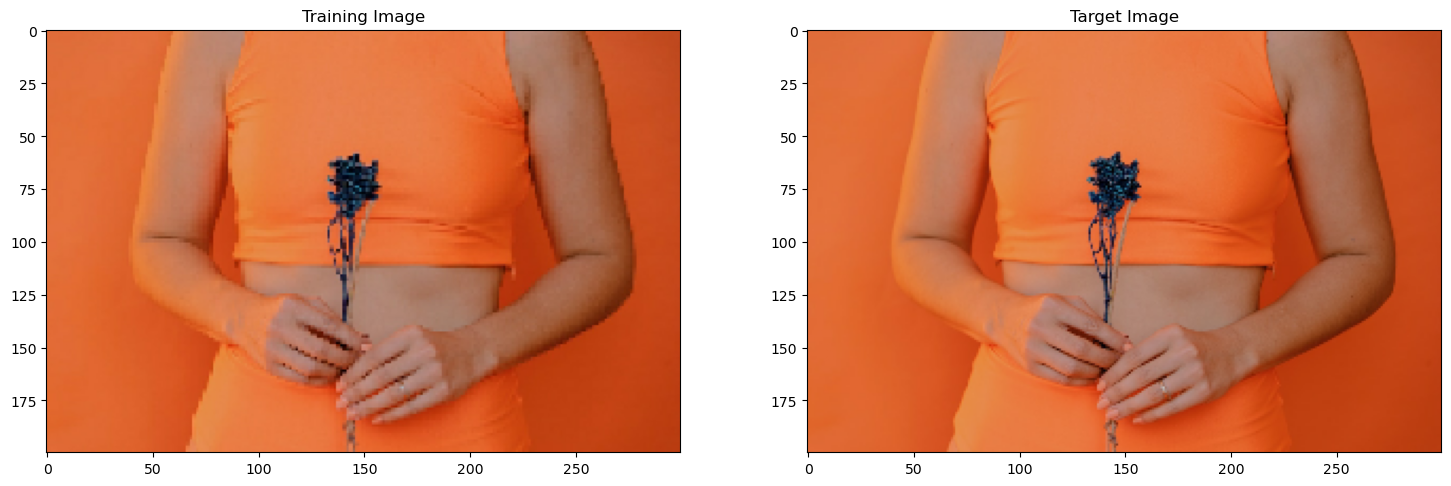

In [8]:
# Create an iterator for the train_dataset
train_iterator = iter(train_dataset)

# Get a batch of training examples
batch_of_images, batch_of_targets = next(train_iterator)

# Visualize the first training example and its target
sample_training_image = batch_of_images[0].numpy()
sample_target_image = batch_of_targets[0].numpy()

# Display the images
plt.figure(figsize=(18, 14))
plt.subplot(1, 2, 1)
plt.imshow(sample_training_image)
plt.title("Training Image")

plt.subplot(1, 2, 2)
plt.imshow(sample_target_image)
plt.title("Target Image")

plt.show()

In [9]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr_plateau = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, verbose=1)
tensorboard = TensorBoard(log_dir='logs')

In [10]:
def make_generator_model(input_shape=INPUT_SHAPE):
    # Input layer
    input_img = Input(shape=input_shape)

    # Convolutional layers
    conv1 = Conv2D(8, (3, 3), padding='same', activation='elu')(input_img)
    conv2 = Conv2D(16, (3, 3), padding='same', activation='elu')(conv1)
    conv3 = Conv2D(32, (3, 3), padding='same', activation='elu')(conv2)
    conv4 = Conv2D(64, (3, 3), padding='same', activation='elu')(conv3)
    concat1 = concatenate([conv2, conv4], axis=-1)
    conv5 = Conv2D(64, (3, 3), padding='same', activation='elu')(concat1)
    output_img = Conv2D(3, (3, 3), padding='same', activation='sigmoid')(conv5)

    # Create the model
    generator_model = Model(inputs=input_img, outputs=output_img)
    return generator_model

def make_discriminator_model(input_shape=INPUT_SHAPE):
    # Input layer
    input_img = Input(shape=input_shape)

    # Convolutional layers
    conv1 = Conv2D(8, (7, 7), activation='relu')(input_img)
    conv2 = Conv2D(16, (7, 7), activation='relu')(conv1)
    conv3 = Conv2D(32, (7, 7), activation='relu')(conv2)
    conv4 = Conv2D(4, (7, 7), activation='relu')(conv3)
    maxpool1 = MaxPooling2D((7, 7))(conv4)
    flatten = Flatten()(maxpool1)
    output_img = Dense(1, activation='sigmoid')(flatten)

    # Create the model
    discriminator_model = Model(inputs=input_img, outputs=output_img)
    return discriminator_model

generator = make_generator_model()
discriminator = make_discriminator_model()

In [11]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=False)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [12]:
tf.config.run_functions_eagerly(True)

In [13]:
best_val_loss = float('inf')
early_stopping_patience = 10
early_stopping_counter = 0

train_gen_losses = []
train_disc_losses = []
avr_train_gen_losses = []
avr_train_disc_losses = []
val_gen_losses = []
val_disc_losses = []

mae_list = []
mse_list = []
accuracy_list = []

@tf.function
def train_step(X, y):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        real_output = discriminator(y, training=True)
        generated_images = generator(X, training=True)
        fake_output = discriminator(generated_images, training=True)
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    train_gen_losses.append(gen_loss)
    train_disc_losses.append(disc_loss)

    try:
        mae_list.append(tf.abs(generated_images - y))
        mse_list.append(tf.square(generated_images - y))
        accuracy_list.append(tf.keras.metrics.binary_accuracy(generated_images, y))
    except:
        pass

start_time = time.time()

for epoch in tqdm(range(EPOCHS), desc="Training Epochs", unit="epoch"):
    for batch_X, batch_y in train_dataset:
        train_step(batch_X, batch_y)

    val_losses = []
    val_mae = []
    val_mse = []
    val_accuracy = []

    for val_batch_X, val_batch_y in val_dataset:
        val_real_output = discriminator(val_batch_y, training=False)
        val_generated_images = generator(val_batch_X, training=False)
        val_fake_output = discriminator(val_generated_images, training=False)
        val_gen_loss = generator_loss(val_fake_output)
        val_disc_loss = discriminator_loss(val_real_output, val_fake_output)
        val_losses.append((val_gen_loss, val_disc_loss))

    val_mae.append(np.abs(val_real_output.numpy() - val_fake_output.numpy()))
    val_mse.append(np.square(val_real_output.numpy() - val_fake_output.numpy()))
    val_accuracy.append(tf.keras.metrics.binary_accuracy(val_real_output.numpy(), val_fake_output.numpy()))

    avg_val_gen_loss = tf.reduce_mean([loss[0] for loss in val_losses])
    avg_val_disc_loss = tf.reduce_mean([loss[1] for loss in val_losses])
    avr_train_gen_losses.append(tf.reduce_mean(train_gen_losses))
    avr_train_disc_losses.append(tf.reduce_mean(train_disc_losses))

    mae = tf.reduce_mean(mae_list)
    mse = tf.reduce_mean(mse_list)
    accuracy = tf.reduce_mean(accuracy_list)
    val_gen_losses.append(avg_val_gen_loss)
    val_disc_losses.append(avg_val_disc_loss)

    val_mae = np.array(val_mae)

    print(f"Epoch {epoch + 1}, "
          f"Average Training Generator Loss: {avr_train_gen_losses[-1]}, "
          f"Average Training Discriminator Loss: {avr_train_disc_losses[-1]}, "
          f"Average Validation Generator Loss: {avg_val_gen_loss}, "
          f"Average Validation Discriminator Loss: {avg_val_disc_loss}, "
          f"Average Training MAE: {mae}, "
          f"Average Training MSE: {mse}, "
          f"Average Training Accuracy: {accuracy}"
          f"Average Validation MAE: {tf.reduce_mean(val_mae)}, "
          f"Average Validation MSE: {tf.reduce_mean(val_mse)}, "
          f"Average Validation Accuracy: {tf.reduce_mean(val_accuracy)}",
          )
    
    mae_list = []
    mse_list = []
    accuracy_list = []

    if avg_val_gen_loss < best_val_loss:
        best_val_loss = avg_val_gen_loss
        early_stopping_counter = 0
    else:
        early_stopping_counter += 1

    if early_stopping_counter == early_stopping_patience:
        print(f"Early stopping at epoch {epoch + 1} due to no improvement in validation loss.")
        generator.save_weights('best_generator_weights.h5')
        discriminator.save_weights('best_discriminator_weights.h5')
        break

end_time = time.time()
training_time = end_time - start_time
model_name = "GANs"
time_dict = {model_name: training_time}

print("Finished!")

Training Epochs:   1%|          | 1/100 [00:53<1:28:55, 53.89s/epoch]

Epoch 1, Average Training Generator Loss: 0.7227836847305298, Average Training Discriminator Loss: 1.0295193195343018, Average Validation Generator Loss: 0.7339197993278503, Average Validation Discriminator Loss: 1.360114336013794, Average Training MAE: 0.3851253390312195, Average Training MSE: 0.21852801740169525, Average Training Accuracy: 1.1077878170340227e-08Average Validation MAE: 0.0015200674533843994, Average Validation MSE: 2.3106051685317652e-06, Average Validation Accuracy: 0.0


Training Epochs:   2%|▏         | 2/100 [01:42<1:22:53, 50.75s/epoch]

Epoch 2, Average Training Generator Loss: 0.720894992351532, Average Training Discriminator Loss: 1.2243378162384033, Average Validation Generator Loss: 0.7299965023994446, Average Validation Discriminator Loss: 1.387577772140503, Average Training MAE: 0.413295716047287, Average Training MSE: 0.2619037628173828, Average Training Accuracy: 0.00713919335976243Average Validation MAE: 0.0, Average Validation MSE: 0.0, Average Validation Accuracy: 0.0


Training Epochs:   3%|▎         | 3/100 [02:31<1:20:48, 49.99s/epoch]

Epoch 3, Average Training Generator Loss: 0.7223790287971497, Average Training Discriminator Loss: 1.2786608934402466, Average Validation Generator Loss: 0.720332682132721, Average Validation Discriminator Loss: 1.3869943618774414, Average Training MAE: 0.408816933631897, Average Training MSE: 0.25920966267585754, Average Training Accuracy: 1.107787781506886e-07Average Validation MAE: 0.0, Average Validation MSE: 0.0, Average Validation Accuracy: 0.0


Training Epochs:   4%|▍         | 4/100 [03:20<1:19:21, 49.60s/epoch]

Epoch 4, Average Training Generator Loss: 0.7205216288566589, Average Training Discriminator Loss: 1.3056880235671997, Average Validation Generator Loss: 0.7095731496810913, Average Validation Discriminator Loss: 1.3865411281585693, Average Training MAE: 0.40881723165512085, Average Training MSE: 0.2592099606990814, Average Training Accuracy: 1.107787781506886e-07Average Validation MAE: 0.0, Average Validation MSE: 0.0, Average Validation Accuracy: 0.0


Training Epochs:   5%|▌         | 5/100 [04:09<1:18:04, 49.31s/epoch]

Epoch 5, Average Training Generator Loss: 0.7173625826835632, Average Training Discriminator Loss: 1.321837067604065, Average Validation Generator Loss: 0.7003670930862427, Average Validation Discriminator Loss: 1.3863259553909302, Average Training MAE: 0.408819317817688, Average Training MSE: 0.25921210646629333, Average Training Accuracy: 1.107787781506886e-07Average Validation MAE: 0.0, Average Validation MSE: 0.0, Average Validation Accuracy: 0.0


Training Epochs:   6%|▌         | 6/100 [04:58<1:17:26, 49.43s/epoch]

Epoch 6, Average Training Generator Loss: 0.7140241861343384, Average Training Discriminator Loss: 1.3325833082199097, Average Validation Generator Loss: 0.6950184106826782, Average Validation Discriminator Loss: 1.386295199394226, Average Training MAE: 0.40882134437561035, Average Training MSE: 0.2592141628265381, Average Training Accuracy: 1.107787781506886e-07Average Validation MAE: 0.0, Average Validation MSE: 0.0, Average Validation Accuracy: 0.0


Training Epochs:   7%|▋         | 7/100 [05:47<1:16:18, 49.23s/epoch]

Epoch 7, Average Training Generator Loss: 0.7111580967903137, Average Training Discriminator Loss: 1.3402564525604248, Average Validation Generator Loss: 0.6933457255363464, Average Validation Discriminator Loss: 1.3862910270690918, Average Training MAE: 0.4088197946548462, Average Training MSE: 0.25921252369880676, Average Training Accuracy: 1.107787781506886e-07Average Validation MAE: 0.0, Average Validation MSE: 0.0, Average Validation Accuracy: 0.0


Training Epochs:   8%|▊         | 8/100 [06:37<1:15:36, 49.31s/epoch]

Epoch 8, Average Training Generator Loss: 0.7089141607284546, Average Training Discriminator Loss: 1.3460111618041992, Average Validation Generator Loss: 0.6931517720222473, Average Validation Discriminator Loss: 1.386290192604065, Average Training MAE: 0.4088197946548462, Average Training MSE: 0.25921252369880676, Average Training Accuracy: 1.107787781506886e-07Average Validation MAE: 0.0, Average Validation MSE: 0.0, Average Validation Accuracy: 0.0


Training Epochs:   9%|▉         | 9/100 [07:25<1:14:22, 49.04s/epoch]

Epoch 9, Average Training Generator Loss: 0.7071623802185059, Average Training Discriminator Loss: 1.3504871129989624, Average Validation Generator Loss: 0.6931473612785339, Average Validation Discriminator Loss: 1.3862887620925903, Average Training MAE: 0.4088197946548462, Average Training MSE: 0.25921252369880676, Average Training Accuracy: 1.107787781506886e-07Average Validation MAE: 0.0, Average Validation MSE: 0.0, Average Validation Accuracy: 0.0


Training Epochs:  10%|█         | 10/100 [08:14<1:13:36, 49.07s/epoch]

Epoch 10, Average Training Generator Loss: 0.7057608366012573, Average Training Discriminator Loss: 1.3540678024291992, Average Validation Generator Loss: 0.6931472420692444, Average Validation Discriminator Loss: 1.3862863779067993, Average Training MAE: 0.4088197946548462, Average Training MSE: 0.25921252369880676, Average Training Accuracy: 1.107787781506886e-07Average Validation MAE: 0.0, Average Validation MSE: 0.0, Average Validation Accuracy: 0.0


Training Epochs:  11%|█         | 11/100 [09:03<1:12:33, 48.91s/epoch]

Epoch 11, Average Training Generator Loss: 0.7046141624450684, Average Training Discriminator Loss: 1.3569974899291992, Average Validation Generator Loss: 0.6931472420692444, Average Validation Discriminator Loss: 1.3862944841384888, Average Training MAE: 0.4088197946548462, Average Training MSE: 0.25921252369880676, Average Training Accuracy: 1.107787781506886e-07Average Validation MAE: 0.0, Average Validation MSE: 0.0, Average Validation Accuracy: 0.0


Training Epochs:  12%|█▏        | 12/100 [09:51<1:11:31, 48.77s/epoch]

Epoch 12, Average Training Generator Loss: 0.7036585807800293, Average Training Discriminator Loss: 1.3594388961791992, Average Validation Generator Loss: 0.6931472420692444, Average Validation Discriminator Loss: 1.3862944841384888, Average Training MAE: 0.4088197946548462, Average Training MSE: 0.25921252369880676, Average Training Accuracy: 1.107787781506886e-07Average Validation MAE: 0.0, Average Validation MSE: 0.0, Average Validation Accuracy: 0.0


Training Epochs:  13%|█▎        | 13/100 [10:40<1:10:51, 48.87s/epoch]

Epoch 13, Average Training Generator Loss: 0.7028499841690063, Average Training Discriminator Loss: 1.3615046739578247, Average Validation Generator Loss: 0.6931472420692444, Average Validation Discriminator Loss: 1.3862944841384888, Average Training MAE: 0.4088197946548462, Average Training MSE: 0.25921252369880676, Average Training Accuracy: 1.107787781506886e-07Average Validation MAE: 0.0, Average Validation MSE: 0.0, Average Validation Accuracy: 0.0


Training Epochs:  14%|█▍        | 14/100 [11:29<1:10:02, 48.87s/epoch]

Epoch 14, Average Training Generator Loss: 0.7021569013595581, Average Training Discriminator Loss: 1.3632752895355225, Average Validation Generator Loss: 0.6931472420692444, Average Validation Discriminator Loss: 1.3862944841384888, Average Training MAE: 0.4088197946548462, Average Training MSE: 0.25921252369880676, Average Training Accuracy: 1.107787781506886e-07Average Validation MAE: 0.0, Average Validation MSE: 0.0, Average Validation Accuracy: 0.0


Training Epochs:  15%|█▌        | 15/100 [12:18<1:09:12, 48.85s/epoch]

Epoch 15, Average Training Generator Loss: 0.7015562653541565, Average Training Discriminator Loss: 1.3648099899291992, Average Validation Generator Loss: 0.6931472420692444, Average Validation Discriminator Loss: 1.3862944841384888, Average Training MAE: 0.4088197946548462, Average Training MSE: 0.25921252369880676, Average Training Accuracy: 1.107787781506886e-07Average Validation MAE: 0.0, Average Validation MSE: 0.0, Average Validation Accuracy: 0.0


Training Epochs:  16%|█▌        | 16/100 [13:08<1:08:41, 49.06s/epoch]

Epoch 16, Average Training Generator Loss: 0.7010306715965271, Average Training Discriminator Loss: 1.3661527633666992, Average Validation Generator Loss: 0.6931472420692444, Average Validation Discriminator Loss: 1.3862944841384888, Average Training MAE: 0.4088197946548462, Average Training MSE: 0.25921252369880676, Average Training Accuracy: 1.107787781506886e-07Average Validation MAE: 0.0, Average Validation MSE: 0.0, Average Validation Accuracy: 0.0


Training Epochs:  17%|█▋        | 17/100 [13:57<1:07:57, 49.13s/epoch]

Epoch 17, Average Training Generator Loss: 0.7005669474601746, Average Training Discriminator Loss: 1.3673375844955444, Average Validation Generator Loss: 0.6931472420692444, Average Validation Discriminator Loss: 1.3862944841384888, Average Training MAE: 0.4088197946548462, Average Training MSE: 0.25921252369880676, Average Training Accuracy: 1.107787781506886e-07Average Validation MAE: 0.0, Average Validation MSE: 0.0, Average Validation Accuracy: 0.0


Training Epochs:  18%|█▊        | 18/100 [14:46<1:07:16, 49.22s/epoch]

Epoch 18, Average Training Generator Loss: 0.700154721736908, Average Training Discriminator Loss: 1.368390679359436, Average Validation Generator Loss: 0.6931472420692444, Average Validation Discriminator Loss: 1.3862944841384888, Average Training MAE: 0.4088197946548462, Average Training MSE: 0.25921252369880676, Average Training Accuracy: 1.107787781506886e-07Average Validation MAE: 0.0, Average Validation MSE: 0.0, Average Validation Accuracy: 0.0


Training Epochs:  19%|█▉        | 19/100 [15:36<1:06:31, 49.28s/epoch]

Epoch 19, Average Training Generator Loss: 0.6997859477996826, Average Training Discriminator Loss: 1.369333028793335, Average Validation Generator Loss: 0.6931472420692444, Average Validation Discriminator Loss: 1.3862944841384888, Average Training MAE: 0.4088197946548462, Average Training MSE: 0.25921252369880676, Average Training Accuracy: 1.107787781506886e-07Average Validation MAE: 0.0, Average Validation MSE: 0.0, Average Validation Accuracy: 0.0


Training Epochs:  19%|█▉        | 19/100 [16:26<1:10:06, 51.94s/epoch]

Epoch 20, Average Training Generator Loss: 0.6994540095329285, Average Training Discriminator Loss: 1.3701810836791992, Average Validation Generator Loss: 0.6931472420692444, Average Validation Discriminator Loss: 1.3862944841384888, Average Training MAE: 0.4088197946548462, Average Training MSE: 0.25921252369880676, Average Training Accuracy: 1.107787781506886e-07Average Validation MAE: 0.0, Average Validation MSE: 0.0, Average Validation Accuracy: 0.0
Early stopping at epoch 20 due to no improvement in validation loss.
Finished!


(1, 200, 300, 3)
(1, 200, 300, 3)
(1, 200, 300, 3)


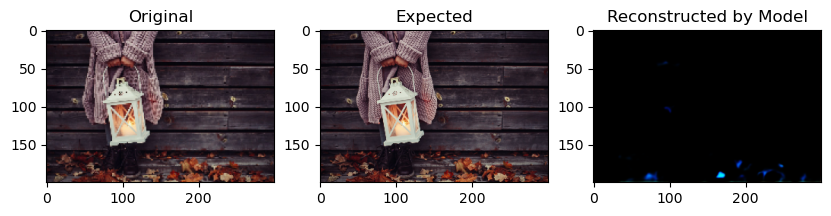

In [17]:
# Create an iterator for the train_dataset
train_iterator = iter(test_dataset)

# Get a batch of training examples
batch_of_images, batch_of_targets = next(train_iterator)

# Visualize the first training example and its target
x_sample = batch_of_images.numpy()
y_sample = batch_of_targets.numpy()

# Predict
y_pred = generator.predict(x_sample, verbose=False)

print(f"{x_sample.shape}\n{y_sample.shape}\n{y_pred.shape}")

# Plot
plt.figure(figsize=((10, 20)))
plt.subplot(1, 3, 1)
plt.imshow(x_sample[0], cmap='gray')
plt.title('Original')

plt.subplot(1, 3, 2)
plt.imshow(y_sample[0], cmap='gray')
plt.title('Expected')

plt.subplot(1, 3, 3)
plt.imshow(y_pred[0], cmap='gray')
plt.title('Reconstructed by Model')

plt.show()

In [15]:
# def build_conv_model(input_shape=INPUT_SHAPE):
#     # Input layer
#     input_img = Input(shape=input_shape)

#     # Convolutional layers
#     conv1 = Conv2D(16, (3, 3), padding='same', activation='elu')(input_img)
#     conv2 = Conv2D(32, (3, 3), padding='same', activation='elu')(conv1)
#     conv3 = Conv2D(64, (3, 3), padding='same', activation='elu')(conv2)
#     conv4 = Conv2D(32, (3, 3), padding='same', activation='elu')(conv3)
#     conv5 = Conv2D(16, (3, 3), padding='same', activation='elu')(conv4)

#     # Output layer
#     output_img = Conv2D(3, (3, 3), padding='same', activation='sigmoid')(conv5)

#     conv_model = Model(input_img, output_img)
#     metrics_list = ['accuracy', MeanAbsoluteError(name='mae'), RootMeanSquaredError(name='rmse')]
#     conv_model.compile(optimizer='adam', loss='mean_squared_error', metrics=metrics_list)

#     return conv_model

# conv_model = build_conv_model()

In [16]:
# history = conv_model.fit(
#     train_dataset,
#     epochs=EPOCHS,
#     validation_data = val_dataset,
#     callbacks=[early_stopping, reduce_lr_plateau]
# )